# Generate figures for the paper

We use this notebook to generate all figures for the paper. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pip install scikit-learn joblib seaborn -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from matchms.filtering import (
    normalize_intensities,
    reduce_to_number_of_peaks,
    require_minimum_number_of_peaks,
    select_by_mz,
    select_by_relative_intensity,
)
from matchms.importing import load_from_mgf
from matchms.similarity import CosineGreedy, ModifiedCosine
from numba import cuda
from sklearn.linear_model import LinearRegression
from simms.similarity import CudaCosineGreedy, CudaModifiedCosine
from simms.utils import Timer, download, get_correct_scores


np.random.seed(42)
sns.set_palette("muted")
plt.rcParams.update({"font.family": "serif", "font.size": 12})
plt.rcParams.update({"axes.titleweight": "bold"})
plt.rcParams["axes.grid"] = True  # Enable grid by default
plt.rcParams["grid.color"] = "gray"  # Grid line color
plt.rcParams["grid.linestyle"] = "--"  # Grid line style (e.g., '-', '--', ':', '-.')
plt.rcParams["grid.linewidth"] = 0.5  # Grid line width
plt.rcParams["grid.alpha"] = 0.7  # Grid transparency
plt.rcParams["axes.labelsize"] = 14  # Font size for x-axis and y-axis labels
plt.rcParams["axes.titlesize"] = 16  # Font size for the title
plt.rcParams["figure.figsize"] = [8, 8]
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 600

assert cuda.is_available()

We define the limits for variables under investigation for the plots.

In [4]:
# We compare pairwise similarity performance on `spectra_file`
# We can use pickled version for much faster loading times
SPECTRA_FILE = "GNPS-random-10k.mgf"

# spectra_file = "MASSBANK.mgf"  # Smaller set for faster runs

# How many spectra to sample for reference and query, this is quite small for a GPU, but we use
# it to keep MatchMS similarity fast, to obtain "correct" scores for equivalence compairson
N_SPECTRA = 512 * 4

# limits for testing tolerance influence on performance
MIN_TOLERANCE = 1e-6
MAX_TOLERANCE = 10.0

# limits for testing match_limit influence on performance
MIN_MATCH_LIMIT = 8
MAX_MATCH_LIMIT = 2048 * 2

# limits for testing num peaks influence on performance
MIN_NUM_PEAKS = 32
MAX_NUM_PEAKS = 2048

# Max evals
NUM_EVALS = 16

# Default params
N_MAX_PEAKS = 1024

# Hardware matters! These results are only repeatable using this GPU (shown as an output)
! nvidia-smi -L
! echo Number of CPU cores $(nproc)

GPU 0: NVIDIA GeForce RTX 4090 (UUID: GPU-401bcd7b-f17f-bb16-82fd-747a1decff2f)
Number of CPU cores 256


In [5]:
spectra = list(load_from_mgf(str(download(SPECTRA_FILE))))
spectra[:5]

[Spectrum(precursor m/z=827.32, 10 fragments between 79.1 and 137.1),
 Spectrum(precursor m/z=555.42, 75 fragments between 51.9 and 555.4),
 Spectrum(precursor m/z=520.36, 88 fragments between 47.1 and 522.4),
 Spectrum(precursor m/z=890.48, 1 fragments between 302.1 and 302.1),
 Spectrum(precursor m/z=385.16, 49 fragments between 50.1 and 386.2)]

# Accuracy with minimal filters

In [6]:
np.random.seed(42)

references = np.random.choice(
    spectra,
    size=N_SPECTRA,
)

queries = np.random.choice(
    spectra,
    size=N_SPECTRA,
)


def process_spectrum(spectrum):
    """
    Suggested way to filter the given spectra.
    """
    spectrum = select_by_mz(spectrum, mz_to=1000.0)
    spectrum = normalize_intensities(spectrum)
    spectrum = select_by_relative_intensity(spectrum, intensity_from=0.001)
    spectrum = reduce_to_number_of_peaks(spectrum, n_max=N_MAX_PEAKS)
    spectrum = require_minimum_number_of_peaks(spectrum, n_required=1)
    return spectrum


references = list(process_spectrum(s) for s in references)
references = list(r for r in references if r is not None)

queries = list(process_spectrum(s) for s in queries)
queries = list(r for r in queries if r is not None)

smallest_reference = min(len(sp.peaks) for sp in references)
smallest_query = min(len(sp.peaks) for sp in queries)

print(f"Smallest reference: {smallest_reference} peaks")
print(f"Smallest query: {smallest_query} peaks")
print(
    f"Number of comaprisons {len(references)} * {len(queries)} = {len(references) * len(queries)}"
)
references[:5], queries[:5]

Smallest reference: 1 peaks
Smallest query: 1 peaks
Number of comaprisons 2038 * 2036 = 4149368


([Spectrum(precursor m/z=306.21, 26 fragments between 58.0 and 326.2),
  Spectrum(precursor m/z=195.09, 60 fragments between 50.6 and 201.5),
  Spectrum(precursor m/z=261.03, 11 fragments between 94.0 and 199.0),
  Spectrum(precursor m/z=872.77, 27 fragments between 91.9 and 841.8),
  Spectrum(precursor m/z=753.23, 1 fragments between 753.2 and 753.2)],
 [Spectrum(precursor m/z=233.66, 178 fragments between 55.1 and 379.8),
  Spectrum(precursor m/z=433.33, 142 fragments between 79.1 and 465.3),
  Spectrum(precursor m/z=277.05, 11 fragments between 77.0 and 277.0),
  Spectrum(precursor m/z=321.07, 18 fragments between 98.1 and 321.2),
  Spectrum(precursor m/z=229.03, 6 fragments between 228.1 and 257.2)])

### Greedy Cosine

In [7]:
batch_size = max(len(references), len(queries))

# Default arguments match in both...
scores = get_correct_scores(
    references=references, queries=queries, similarity_class=CosineGreedy
)

In [8]:
scores_cu = CudaCosineGreedy(
    n_max_peaks=N_MAX_PEAKS,
    batch_size=batch_size,
).matrix(references, queries)

### Modified Cosine

In [9]:
batch_size = max(len(references), len(queries))

scores_modified = get_correct_scores(
    references=references, queries=queries, similarity_class=ModifiedCosine
)

In [10]:
# from simms.similarity import CudaModifiedCosine
scores_cu_modified = CudaModifiedCosine(
    n_max_peaks=N_MAX_PEAKS, batch_size=batch_size
).matrix(references, queries)

### Direct comparison

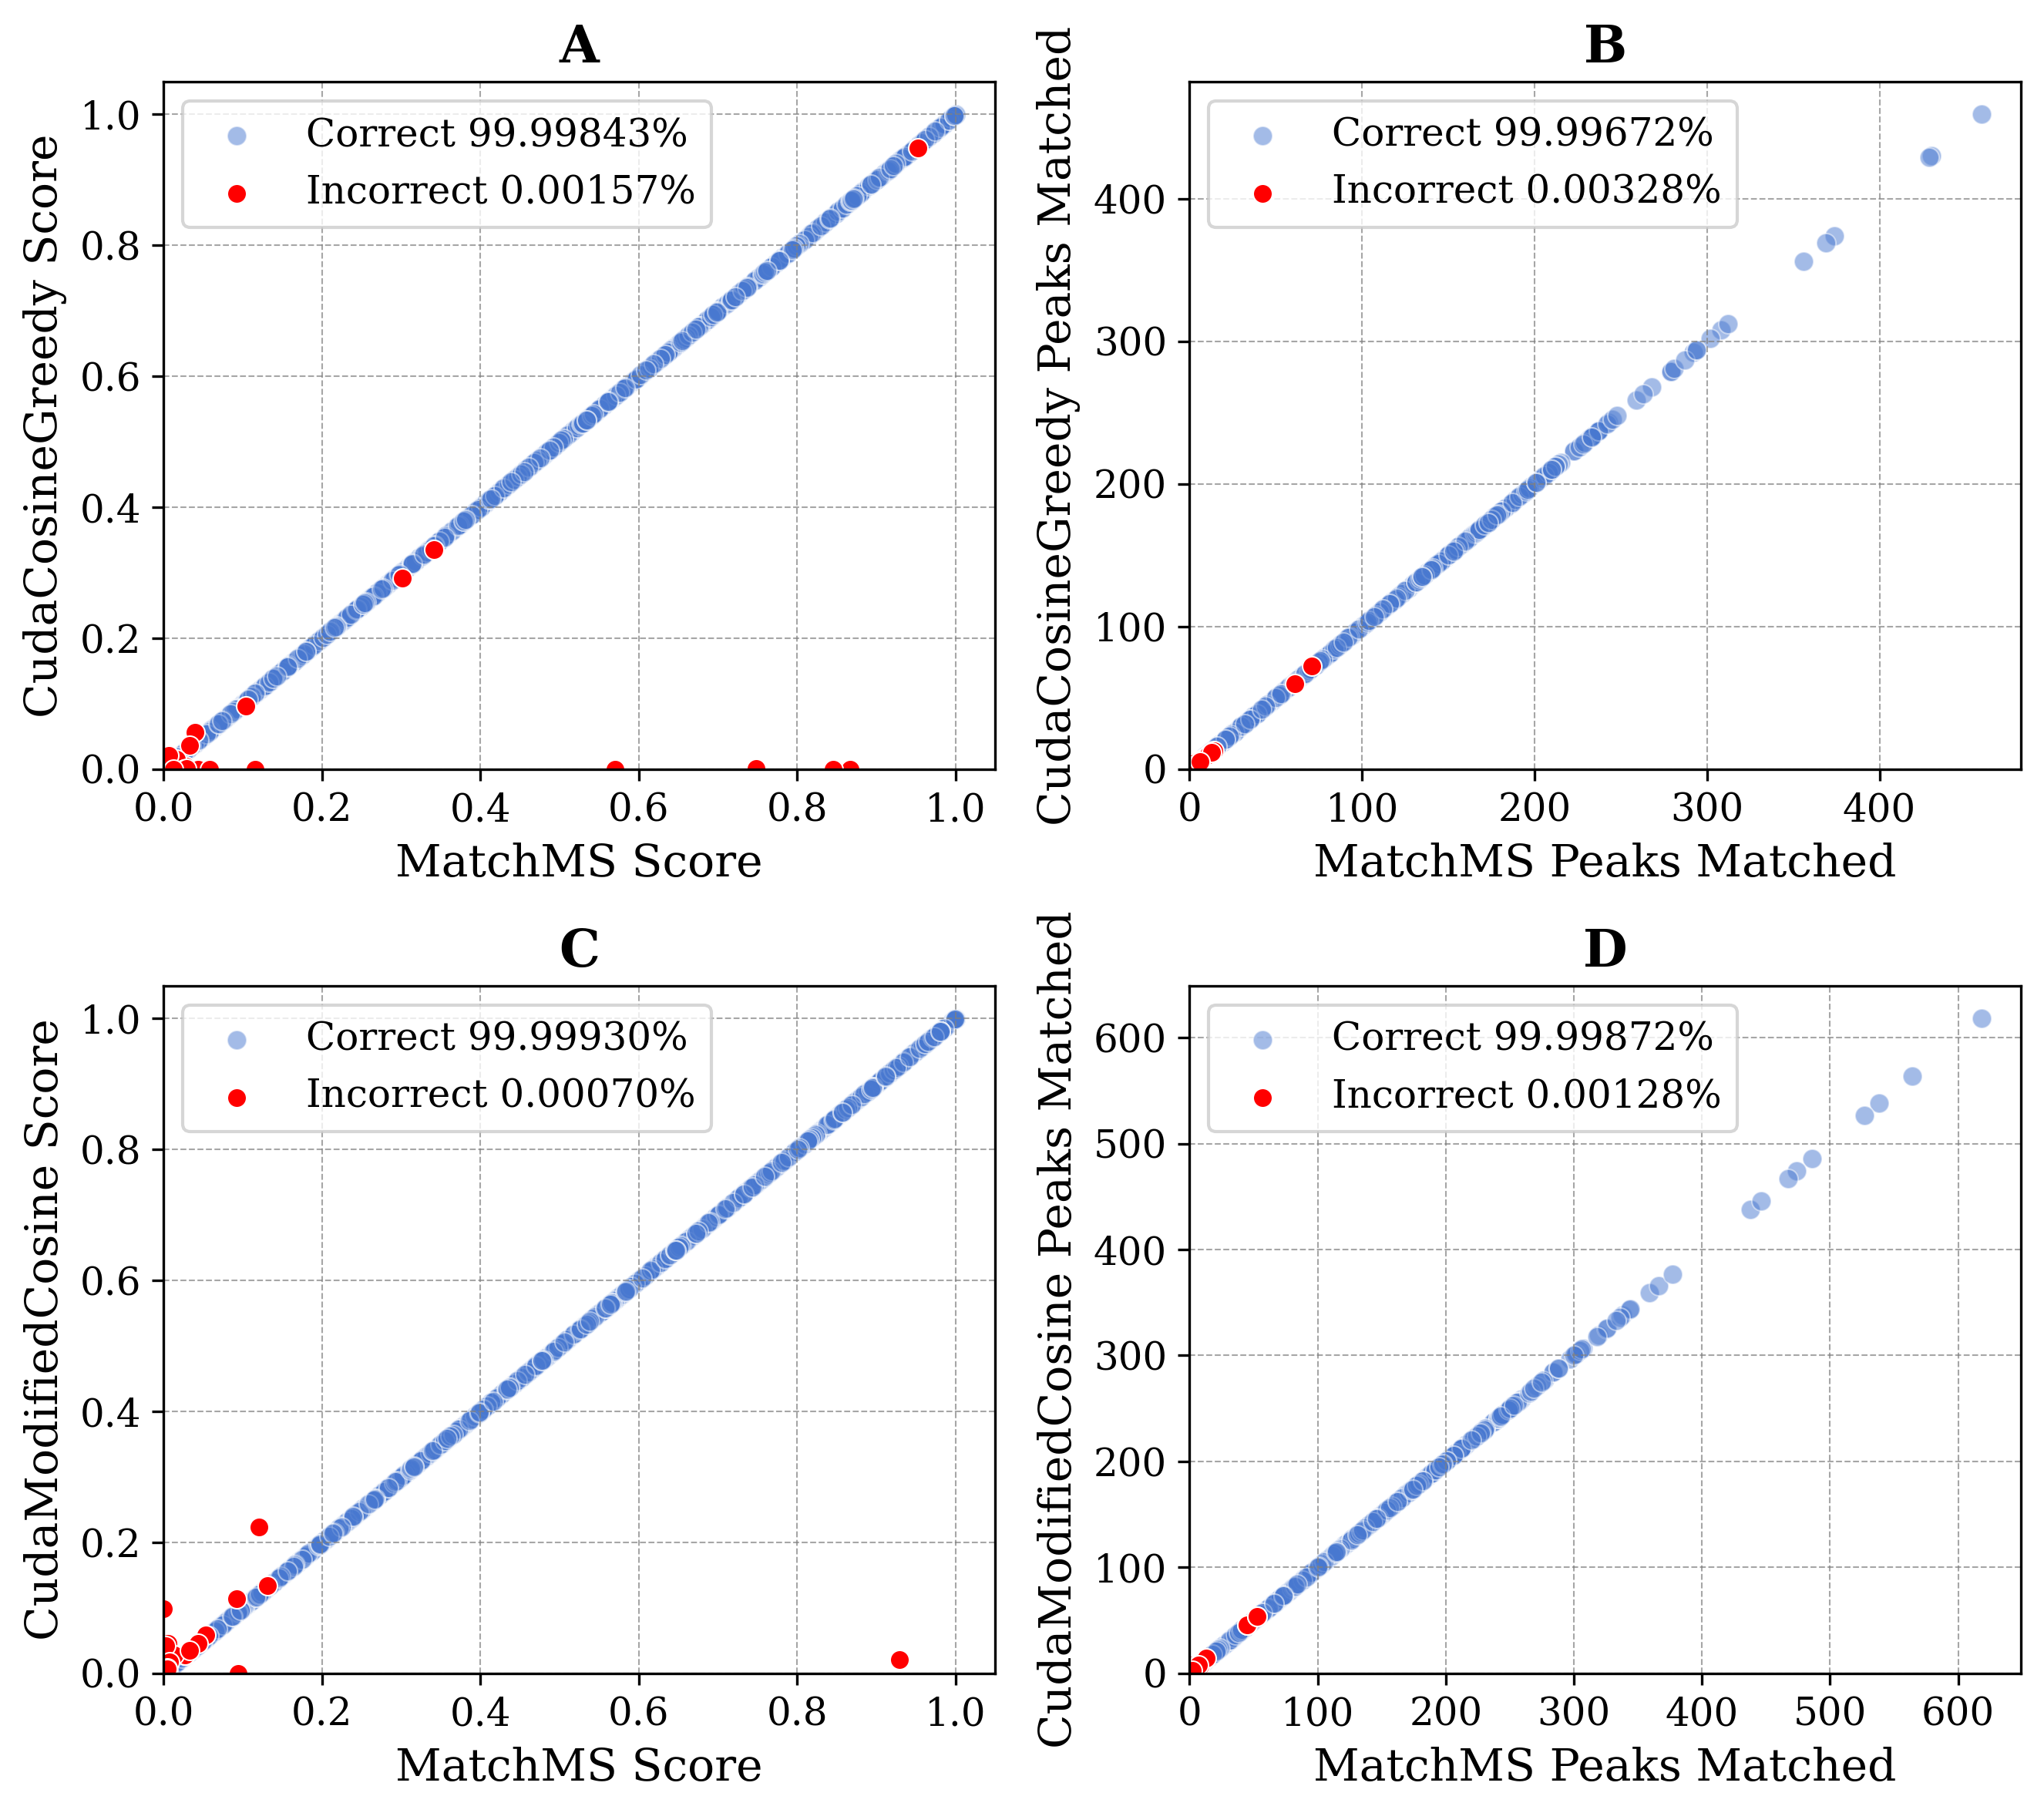

In [11]:
# Takes a good minute or two
fig, axs = plt.subplots(2, 2, figsize=(9, 8))
labels = ["A", "B", "C", "D"]
plots_data = [
    (
        scores,
        scores_cu,
        "MatchMS Score",
        "CudaCosineGreedy Score",
        "MatchMS Peaks Matched",
        "CudaCosineGreedy Peaks Matched",
    ),
    (
        scores_modified,
        scores_cu_modified,
        "MatchMS Score",
        "CudaModifiedCosine Score",
        "MatchMS Peaks Matched",
        "CudaModifiedCosine Peaks Matched",
    ),
]

for i, (
    score,
    score_cu,
    xlabel_score,
    ylabel_score,
    xlabel_matches,
    ylabel_matches,
) in enumerate(plots_data):
    row, col = divmod(i * 2, 2)

    # Scores Plot
    ax = axs[row, col]
    simms_scores = score_cu["score"].ravel()
    matchms_scores = score["score"].ravel()
    is_overflow = score_cu["overflow"].ravel() == 1

    is_correct = np.isclose(simms_scores, matchms_scores, atol=0.001)
    is_wrong = ~is_correct

    # Subsample only 10% of corrects, since they are so numerous
    is_correct_selected = is_correct & (np.random.rand(len(is_correct)) > 0.95)

    is_wrong_without_warning = is_wrong & ~is_overflow
    is_wrong_with_warning = is_wrong & is_overflow

    plt.sca(ax)
    sns.scatterplot(
        x=simms_scores[is_correct_selected],
        y=matchms_scores[is_correct_selected],
        alpha=0.5,
        label=f"Correct {is_correct.mean()*100:.5f}%",
        ax=ax,
    )
    sns.scatterplot(
        x=matchms_scores[is_wrong_with_warning],
        y=simms_scores[is_wrong_with_warning],
        color="orange",
        label=f"Overflow {is_wrong_with_warning.mean()*100:.5f}%",
        ax=ax,
    )
    sns.scatterplot(
        x=matchms_scores[is_wrong_without_warning],
        y=simms_scores[is_wrong_without_warning],
        color="red",
        label=f"Incorrect {(is_wrong_without_warning).mean()*100:.5f}%",
        ax=ax,
    )
    plt.legend(loc="upper left")
    plt.xlabel(xlabel_score)
    plt.ylabel(ylabel_score)
    plt.ylim([0, None])
    plt.xlim([0, None])
    plt.title(labels[i * 2])

    # Matches Plot
    ax = axs[row, col + 1]
    simms_matches = score_cu["matches"].ravel()
    matchms_matches = score["matches"].ravel()
    is_overflow = score_cu["overflow"].ravel() == 1

    is_correct = np.isclose(simms_matches, matchms_matches, atol=0.001)
    is_wrong = ~is_correct
    is_correct_selected = is_correct & (np.random.rand(len(is_correct)) > 0.95)
    is_wrong_without_warning = is_wrong & ~is_overflow
    is_wrong_with_warning = is_wrong & is_overflow

    plt.sca(ax)
    sns.scatterplot(
        x=matchms_matches[is_correct_selected],
        y=simms_matches[is_correct_selected],
        alpha=0.5,
        label=f"Correct {is_correct.mean()*100:.5f}%",
        ax=ax,
    )

    sns.scatterplot(
        x=matchms_matches[is_wrong_with_warning],
        y=simms_matches[is_wrong_with_warning],
        color="orange",
        label=f"Overflow {is_wrong_with_warning.mean()*100:.5f}%",
        ax=ax,
    )

    sns.scatterplot(
        x=matchms_matches[is_wrong_without_warning],
        y=simms_matches[is_wrong_without_warning],
        color="red",
        label=f"Incorrect {(is_wrong_without_warning).mean()*100:.5f}%",
        ax=ax,
    )

    plt.legend(loc="upper left")
    plt.xlabel(xlabel_matches)
    plt.ylabel(ylabel_matches)
    plt.ylim([0, None])
    plt.xlim([0, None])
    plt.title(labels[i * 2 + 1])

plt.tight_layout()
plt.savefig("fig02_direct_acc.png", bbox_inches="tight")
plt.show()

# Greedy Cosine Performance

## Tolerance

In [12]:
from tqdm.cli import tqdm


np.random.seed(123)

references = np.random.choice(
    spectra,
    size=512 * 8,
    replace=False,
)

queries = np.random.choice(
    spectra,
    size=512 * 8,
    replace=False,
)
batch_size = max(len(references), len(queries))

tolerances = np.logspace(
    np.log10(MIN_TOLERANCE), np.log10(MAX_TOLERANCE), endpoint=True, num=NUM_EVALS
)
tolerance_perf_data = []
for tolerance in tqdm(tolerances):
    tolerance = float(tolerance)
    scores = get_correct_scores(
        references=references[:256],
        queries=queries[:256],
        similarity_class=CosineGreedy,
        tolerance=tolerance,
    )
    kernel = CudaCosineGreedy(
        tolerance=tolerance,
        batch_size=batch_size,
    )
    kernel.matrix(references[:4], queries[:4])
    with Timer() as t:
        for _ in range(3):
            scores_cu = kernel.matrix(references, queries)
    tolerance_perf_data.append(
        (scores, scores_cu, t.duration / 3),
    )

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [02:29<00:00,  9.36s/it]


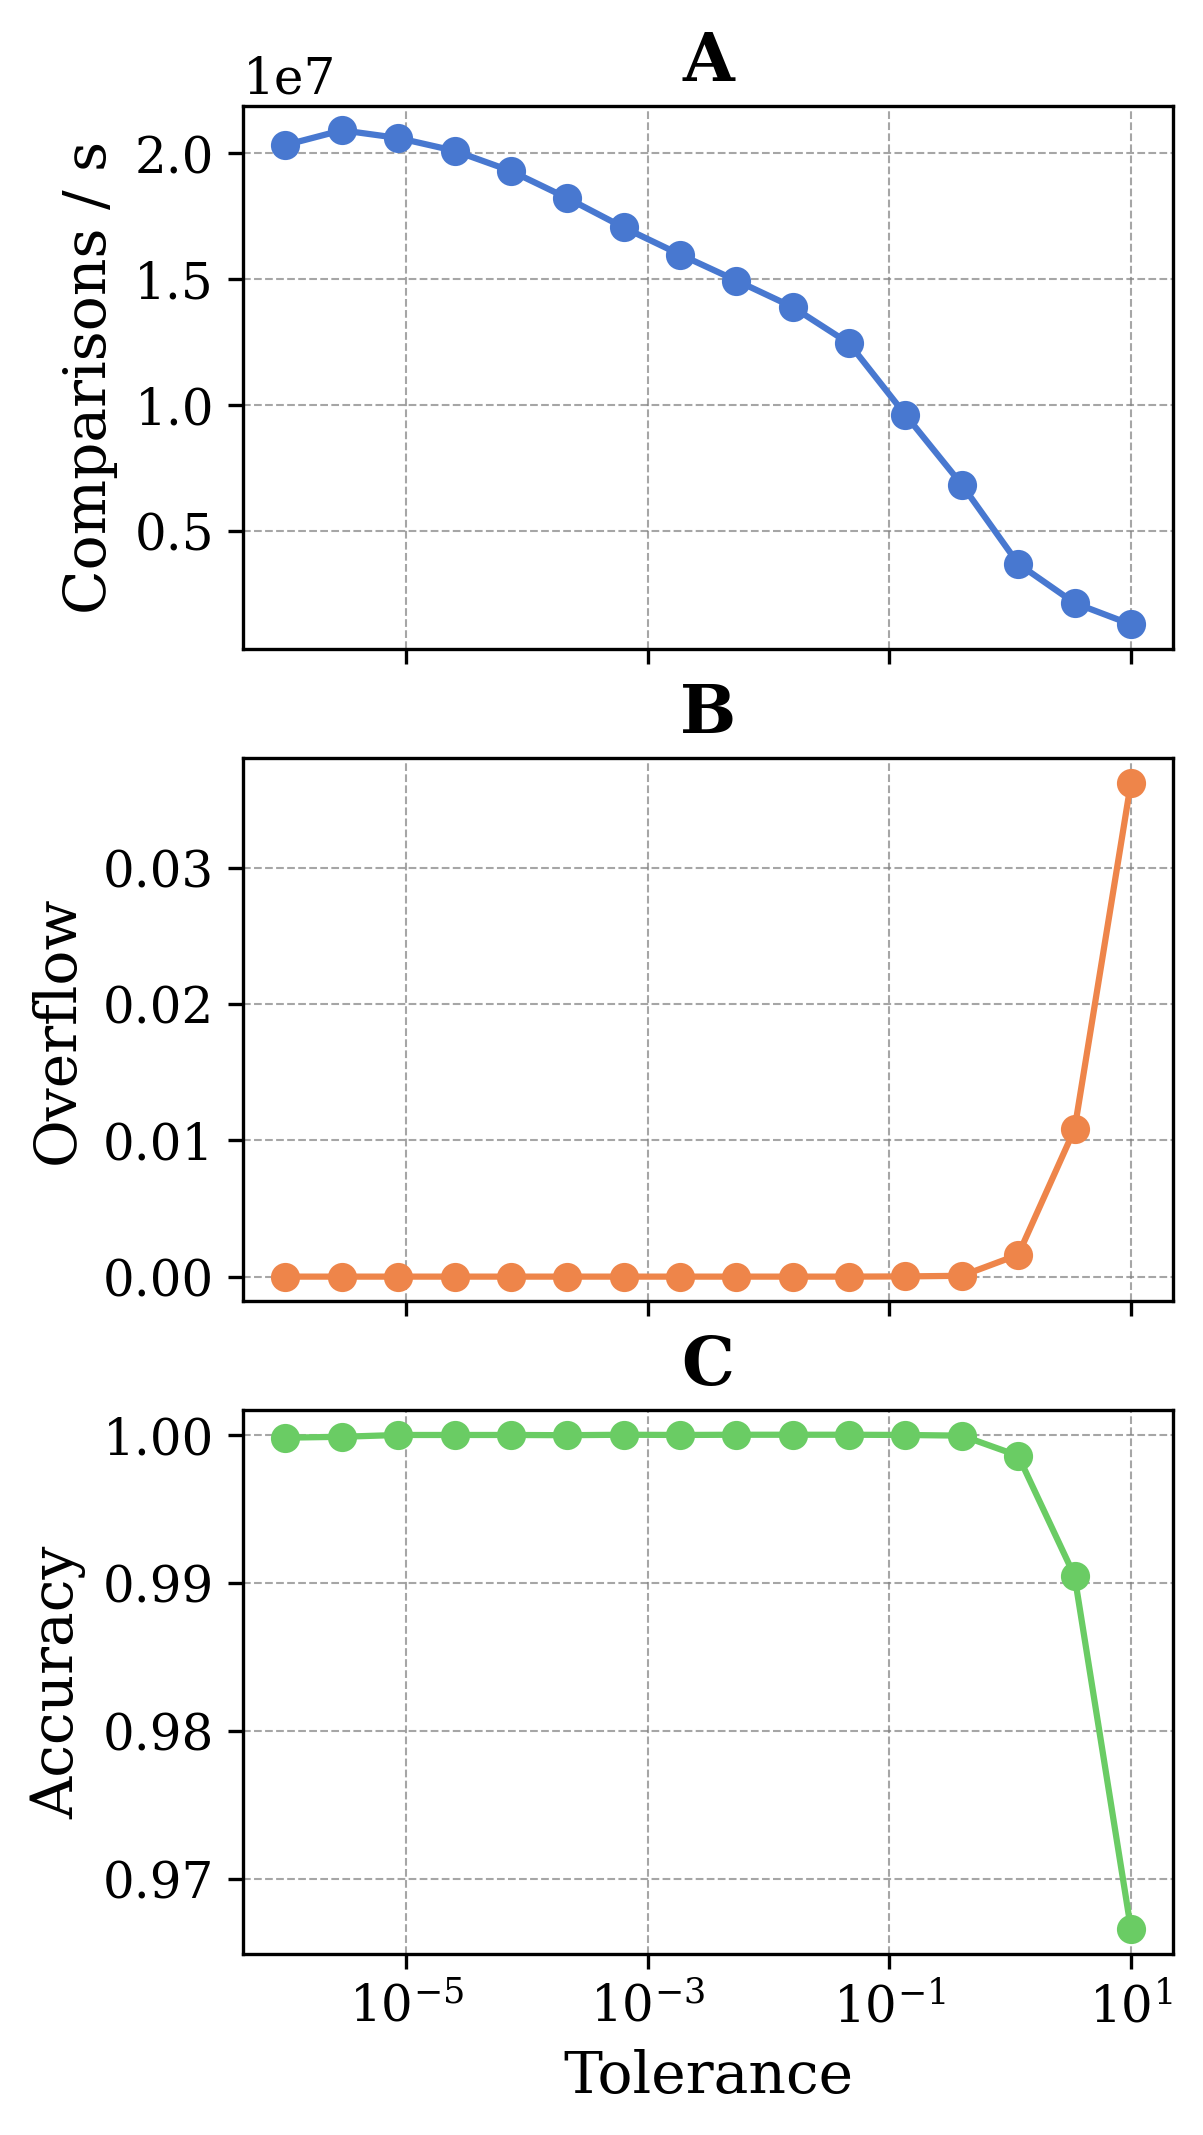

In [13]:
##### We use largest batch size for best error estimates


def plot_tol_and_perf(
    axis: list[plt.Axes] = None,
    data=None,
    tolerances=tolerances,
):
    ov_means = []
    match_means = []
    iseq_means = []
    spectra_per_second = []
    for scores, scores_cu, time_per_batch in data:
        R, Q = scores["score"].shape
        a = scores["score"].ravel()
        am = scores["matches"].ravel()

        ov = scores_cu["overflow"][:R, :Q].ravel() == 1
        b = scores_cu["score"][:R, :Q].ravel()
        bm = scores_cu["matches"][:R, :Q].ravel()
        iseq = np.isclose(a, b, atol=0.001)

        ov_means.append(ov.mean())
        iseq_means.append(iseq.mean())
        match_means.append(bm.mean())
        pairs = len(references) * len(queries)
        spectra_per_second.append(pairs / time_per_batch)

    spectra_per_second = np.array(spectra_per_second)
    prop_cycle = plt.rcParams["axes.prop_cycle"]
    colors = list(prop_cycle.by_key()["color"])

    plt.sca(axis[0])
    sns.set_palette("muted")
    plt.plot(tolerances, spectra_per_second, marker="o", color=colors[0])
    plt.ylabel("Comparisons / s", fontsize=14)
    plt.title("A")

    plt.sca(axis[1])
    plt.plot(tolerances, ov_means, marker="o", color=colors[1])
    plt.ylabel("Overflow", fontsize=14)
    plt.title("B")

    plt.sca(axis[2])
    plt.plot(tolerances, iseq_means, marker="o", color=colors[2])
    plt.xscale("log")
    plt.ylabel("Accuracy")
    plt.xlabel("Tolerance")
    plt.title("C")


fig, axd = plt.subplot_mosaic([["a"], ["b"], ["c"]], figsize=(4, 8), sharex=True)

plot_tol_and_perf(axis=[axd[k] for k in "a b c".split()], data=tolerance_perf_data)

## Match Limit

In [14]:
np.random.seed(111)

match_limits = np.logspace(
    np.log10(MIN_MATCH_LIMIT), np.log10(MAX_MATCH_LIMIT), endpoint=True, num=NUM_EVALS
)

references = np.random.choice(
    spectra,
    size=512 * 8,
    replace=False,
)

queries = np.random.choice(
    spectra,
    size=512 * 8,
    replace=False,
)
batch_size = max(len(references), len(queries))
scores = get_correct_scores(
    references=references[:256],
    queries=queries[:256],
    similarity_class=CosineGreedy,
    tolerance=0.1,
)

In [15]:
match_limit_data = []
for variable in tqdm(match_limits):
    match_limit = int(variable)
    kernel = CudaCosineGreedy(match_limit=match_limit, batch_size=batch_size)
    kernel.matrix(references[:4], queries[:4])
    with Timer() as t:
        for _ in range(3):
            scores_cu = kernel.matrix(references, queries)

    match_limit_data.append((scores, scores_cu, t.duration / 3))

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [01:28<00:00,  5.56s/it]


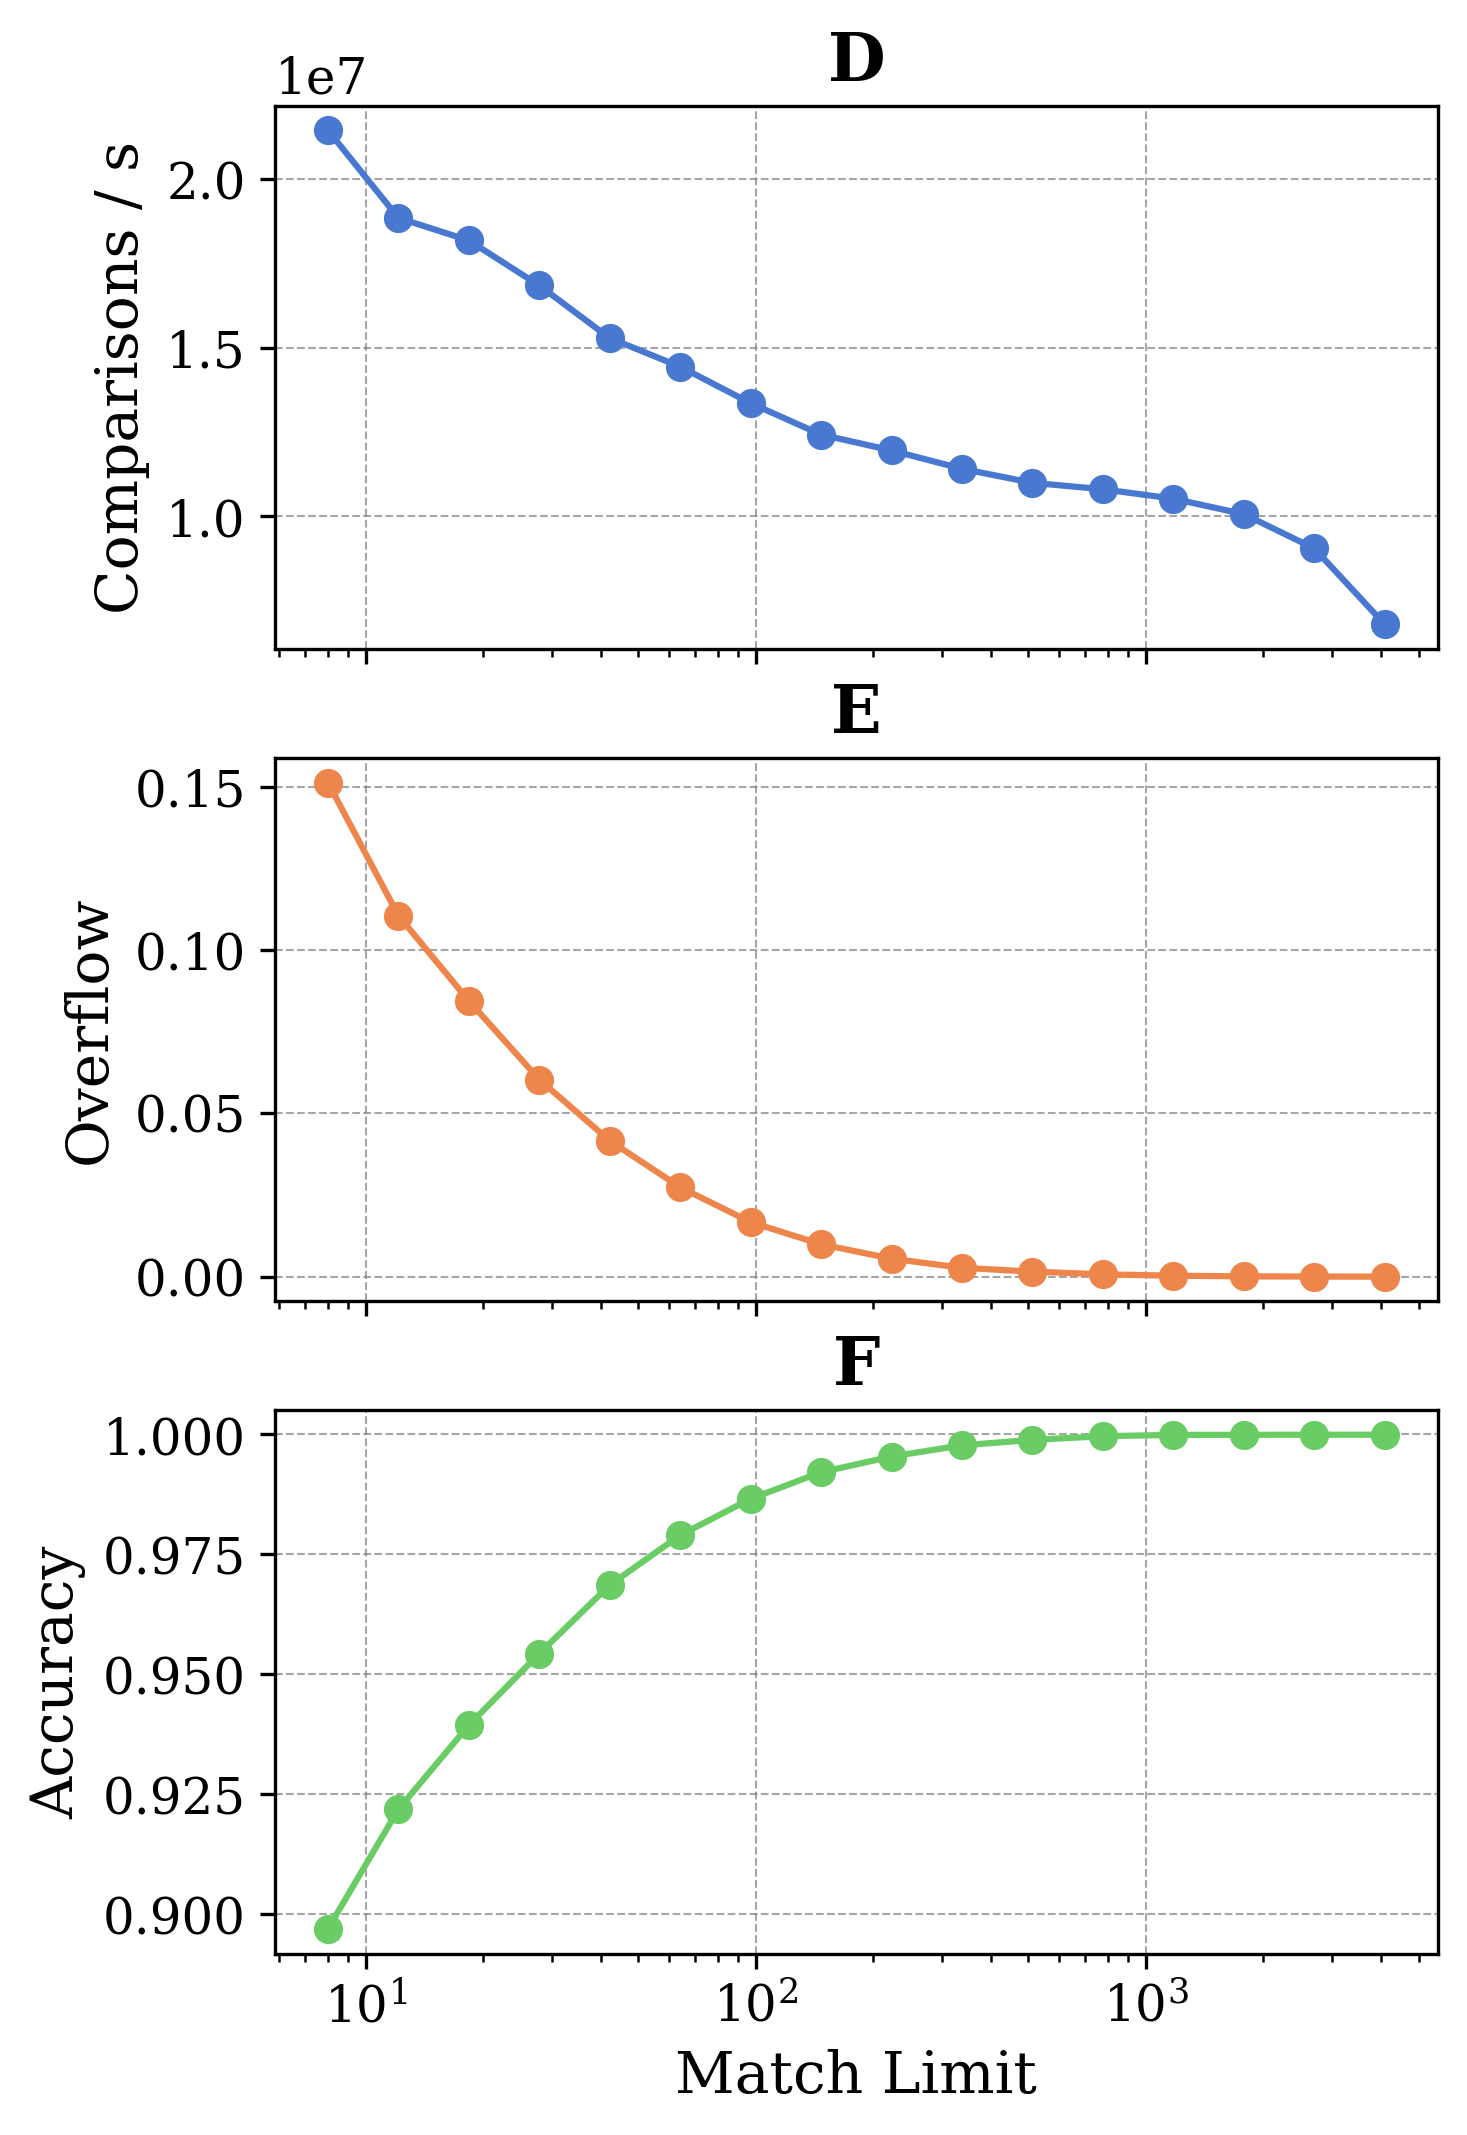

In [16]:
def plot_ml_and_perf(axis: list[plt.Axes] = None, match_limits=match_limits, data=None):
    ov_means = []
    match_means = []
    iseq_means = []
    pairs_per_second = []
    for scores, scores_cu, duration in data:
        R, Q = scores["score"].shape
        a = scores["score"].ravel()
        am = scores["matches"].ravel()

        ov = scores_cu["overflow"][:R, :Q].ravel() == 1
        b = scores_cu["score"][:R, :Q].ravel()
        bm = scores_cu["matches"][:R, :Q].ravel()
        iseq = np.isclose(a, b, atol=0.001)

        ov_means.append(ov.mean())
        iseq_means.append(iseq.mean())
        match_means.append(bm.mean())
        pairs_per_second.append((len(references) * len(queries)) / duration)

    # Convert pairs_per_second to numpy array for consistency
    pairs_per_second = np.array(pairs_per_second)
    prop_cycle = plt.rcParams["axes.prop_cycle"]
    colors = list(prop_cycle.by_key()["color"])

    # Update font settings

    # First plot (A)
    plt.sca(axis[0])
    plt.plot(match_limits, pairs_per_second, marker="o", color=colors[0])
    plt.ylabel("Comparisons / s")
    plt.title("D")

    # Second plot (B)
    plt.sca(axis[1])
    plt.plot(match_limits, ov_means, marker="o", color=colors[1])
    plt.ylabel("Overflow")
    plt.title("E")

    # Third plot (C)
    plt.sca(axis[2])
    plt.plot(match_limits, iseq_means, marker="o", color=colors[2], label="accuracy")
    plt.xscale("log")
    plt.ylabel("Accuracy")
    plt.xlabel("Match Limit")
    plt.title("F")


fig, axd = plt.subplot_mosaic([["a"], ["b"], ["c"]], figsize=(5, 8), sharex=True)

plot_ml_and_perf(
    axis=[axd[k] for k in "a b c".split()],
    data=match_limit_data,
)

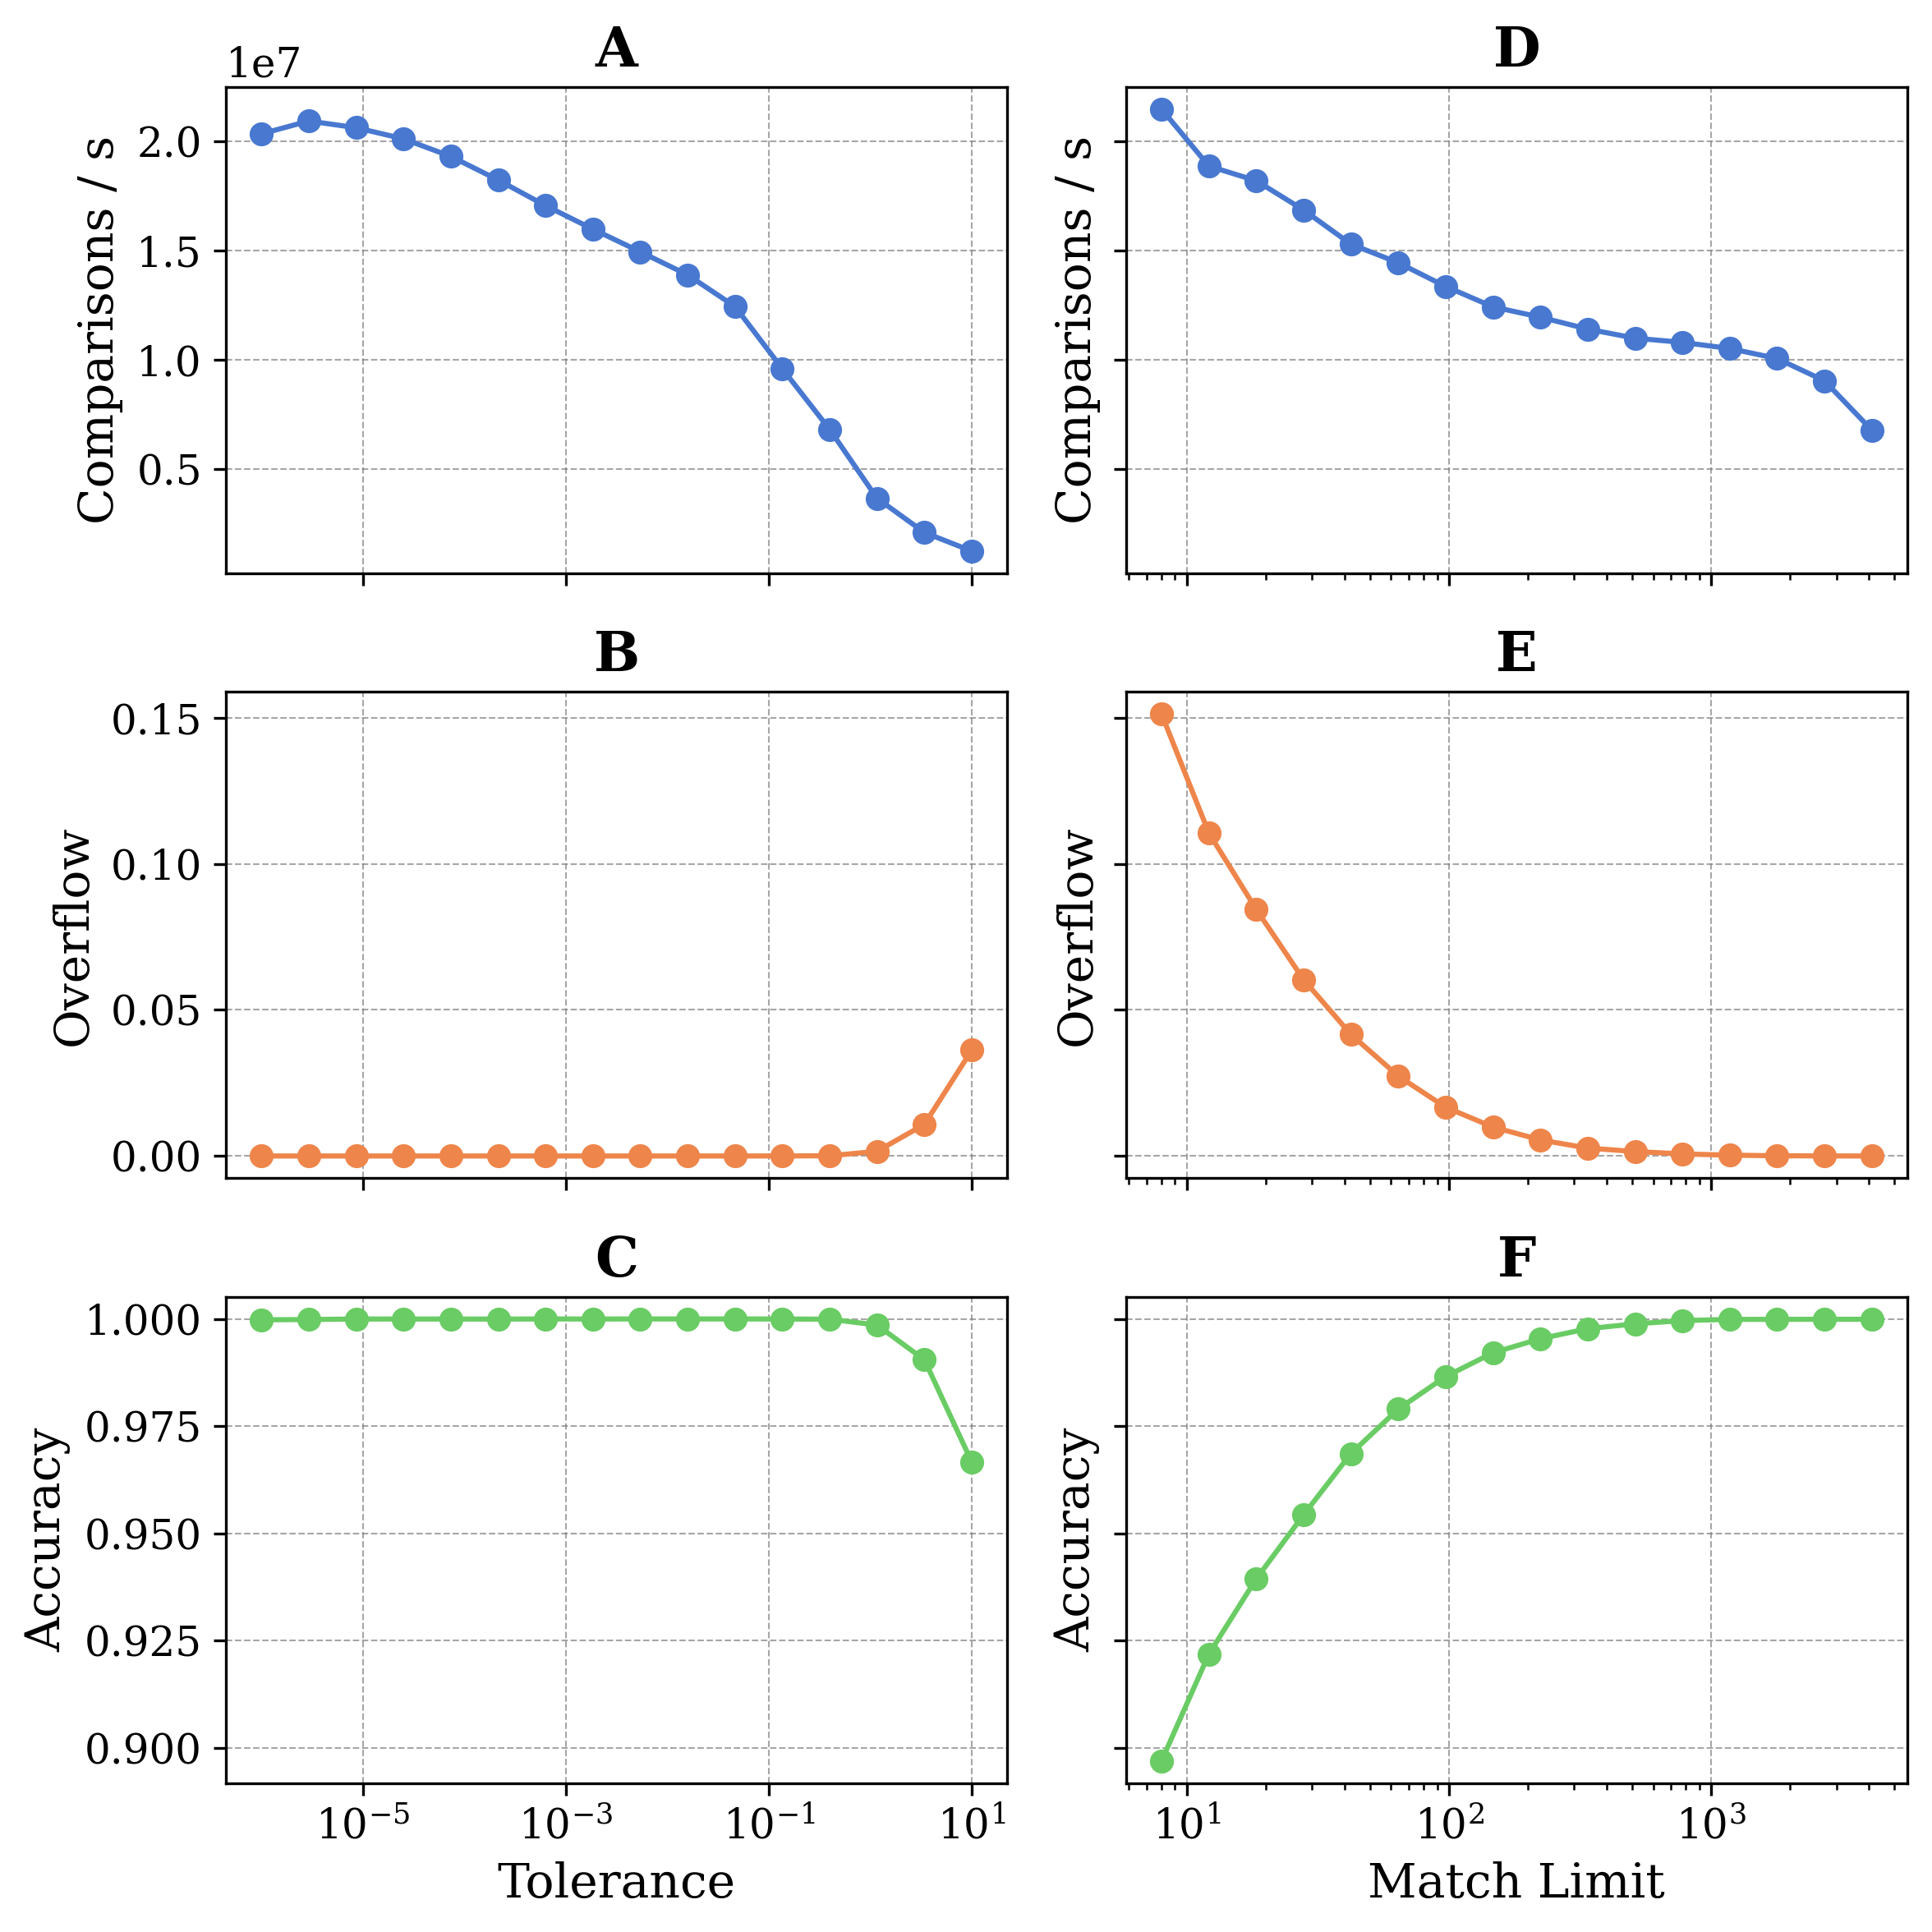

In [17]:
fig, axd = plt.subplots(
    3,
    2,
    figsize=(8, 8),
    sharex="col",
    sharey="row",
)

plot_tol_and_perf(axis=axd[:, 0], data=tolerance_perf_data)
plot_ml_and_perf(axis=axd[:, 1], data=match_limit_data)

plt.tight_layout()
plt.savefig("fig03_tolerance_and_match_limit.png", bbox_inches="tight")
plt.show()

## SimMS vs. BLINK

Compare:

1. Accuracy as a function of tolerance
1. Runtime as a function of total number of comparisonsfor

Accuracy of BLINK decreases at any fixed tolerance as `bin_width` parameter increases. Unfortunately, memory requirements increase as `1/bin_width`.

We use the maximum practical `bin_width` for the current workstation, that doesn't result in OOM.

We use the best possible setup for BLINK, `bin_width=1e-6`.

In [18]:
import blink
import torch
from tqdm.cli import tqdm


tolerances = np.logspace(
    start=-5,
    stop=-1,
    endpoint=True,
    num=8,
)

np.random.seed(123)

references = np.random.choice(
    spectra,
    size=512 * 8,
    replace=False,
)

queries = np.random.choice(
    spectra,
    size=512 * 8,
    replace=False,
)

batch_size = max(len(references), len(queries))
n_reps = 10  # Repeat each kernel 10 times and average to get better estimate of speed performance


def measure_blink_vs_simms():
    data = []
    for tolerance in tqdm(tolerances):
        tolerance = float(tolerance)

        ## MatchMS
        scores = get_correct_scores(
            # NOTE! We only use first 256**2 samples for comparing to matchms accuracy since
            # matchms is incredibly slow at number of samples that we need to saturate GPU resources
            references=references[:256],
            queries=queries[:256],
            similarity_class=CosineGreedy,
            tolerance=tolerance,
        )

        ## SimMS
        kernel = CudaCosineGreedy(
            tolerance=tolerance,
            batch_size=batch_size,
        )
        kernel.matrix(references[:4], queries[:4])

        with Timer() as t_simms:
            for _ in range(n_reps):
                scores_cu = kernel.matrix(references, queries)

        acc = np.isclose(
            scores["score"].ravel(), scores_cu["score"][:256, :256].ravel(), atol=0.001
        ).mean()
        data.append(
            dict(
                method="simms",
                tolerance=tolerance,
                time=t_simms.duration / n_reps,
                acc=acc,
                speed=float(
                    len(references) * len(queries) / (t_simms.duration / n_reps)
                ),
            )
        )

        ## BLINK
        torch.cuda.empty_cache()
        queries_ = [e.peaks.to_numpy.T for e in queries]
        references_ = [e.peaks.to_numpy.T for e in references]
        query_precursor_mz_ = [e.get("precursor_mz") for e in queries]
        reference_precursor_mz_ = [e.get("precursor_mz") for e in references]
        # blink_bin_width = 0.00001
        # blink_bin_width = tolerance / 5
        blink_bin_width = min(
            tolerance, 0.001
        )  # with lower tolerance, it is necessary to use bin width <= tolerance
        # for blink_bin_width in [0.00001, 0.0001, 0.001]:
        # On the one hand, BLINK can only work with tolerances in range (bin_width, bin_width * 1000)
        # On the other, BLINK memory requirements for discretization grow as 1/bin_width.
        # This requires us to use different bin widths for different tolerances and take all configurations into account
        # if tolerance >= blink_bin_width and tolerance <= blink_bin_width * 256:
        print("SET", tolerance, blink_bin_width, 1 / blink_bin_width)
        with Timer() as t_blink:
            for _ in range(n_reps):
                blink_discretized_spectra = blink.discretize_spectra(
                    references_,
                    queries_,
                    reference_precursor_mz_,
                    query_precursor_mz_,
                    intensity_power=1.0,  # since BLINK default is 0.5
                    bin_width=blink_bin_width,
                    tolerance=tolerance,
                )
                blink_results = blink.score_sparse_spectra(
                    blink_discretized_spectra, gpu=True
                )
        acc = np.isclose(
            scores["score"].ravel(),
            blink_results["mzi"].todense()[:256, :256].ravel(),
            atol=0.001,
        ).mean()
        data.append(
            dict(
                method="blink",
                tolerance=tolerance,
                blink_bin_width=blink_bin_width,
                time=t_blink.duration / n_reps,
                speed=float(
                    len(references) * len(queries) / (t_blink.duration / n_reps)
                ),
                acc=acc,
            )
        )
    data = pd.DataFrame(data)
    return data


perf_df = measure_blink_vs_simms()

  0%|          | 0/8 [00:00<?, ?it/s]

SET 1e-05 1e-05 99999.99999999999


/root/blink/blink/spectral_normalization.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  inorm = np.array([1.0/np.linalg.norm(mzi[1]**intensity_power) for mzi in mzis])
/root/blink/blink/scoring.py:14: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /opt/conda/conda-bld/pytorch_1716905979055/work/torch/csrc/utils/tensor_new.cpp:621.)
  return torch.sparse.FloatTensor(i, v, torch.Size(shape))
 12%|█▎        | 1/8 [00:14<01:43, 14.77s/it]

SET 3.727593720314938e-05 3.727593720314938e-05 26826.95795279727


/root/blink/blink/spectral_normalization.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  inorm = np.array([1.0/np.linalg.norm(mzi[1]**intensity_power) for mzi in mzis])
 25%|██▌       | 2/8 [00:29<01:28, 14.73s/it]

SET 0.00013894954943731373 0.00013894954943731373 7196.856730011522


/root/blink/blink/spectral_normalization.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  inorm = np.array([1.0/np.linalg.norm(mzi[1]**intensity_power) for mzi in mzis])
 38%|███▊      | 3/8 [00:44<01:14, 14.85s/it]

SET 0.0005179474679231213 0.0005179474679231213 1930.6977288832495


/root/blink/blink/spectral_normalization.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  inorm = np.array([1.0/np.linalg.norm(mzi[1]**intensity_power) for mzi in mzis])
 50%|█████     | 4/8 [01:00<01:00, 15.23s/it]

SET 0.0019306977288832496 0.001 1000.0


/root/blink/blink/spectral_normalization.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  inorm = np.array([1.0/np.linalg.norm(mzi[1]**intensity_power) for mzi in mzis])
 62%|██████▎   | 5/8 [01:17<00:48, 16.02s/it]

SET 0.007196856730011514 0.001 1000.0


/root/blink/blink/spectral_normalization.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  inorm = np.array([1.0/np.linalg.norm(mzi[1]**intensity_power) for mzi in mzis])
 75%|███████▌  | 6/8 [01:39<00:35, 17.88s/it]

SET 0.026826957952797246 0.001 1000.0


/root/blink/blink/spectral_normalization.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  inorm = np.array([1.0/np.linalg.norm(mzi[1]**intensity_power) for mzi in mzis])
 88%|████████▊ | 7/8 [02:09<00:21, 21.82s/it]

SET 0.1 0.001 1000.0


/root/blink/blink/spectral_normalization.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  inorm = np.array([1.0/np.linalg.norm(mzi[1]**intensity_power) for mzi in mzis])
100%|██████████| 8/8 [03:02<00:00, 22.83s/it]


# Performance plots

Requires us to run notebooks under `notebooks/figures/performance` first, to generate performance accross multiple GPU types.

/tmp/ipykernel_16722/4087498700.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(
/tmp/ipykernel_16722/4087498700.py:44: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(


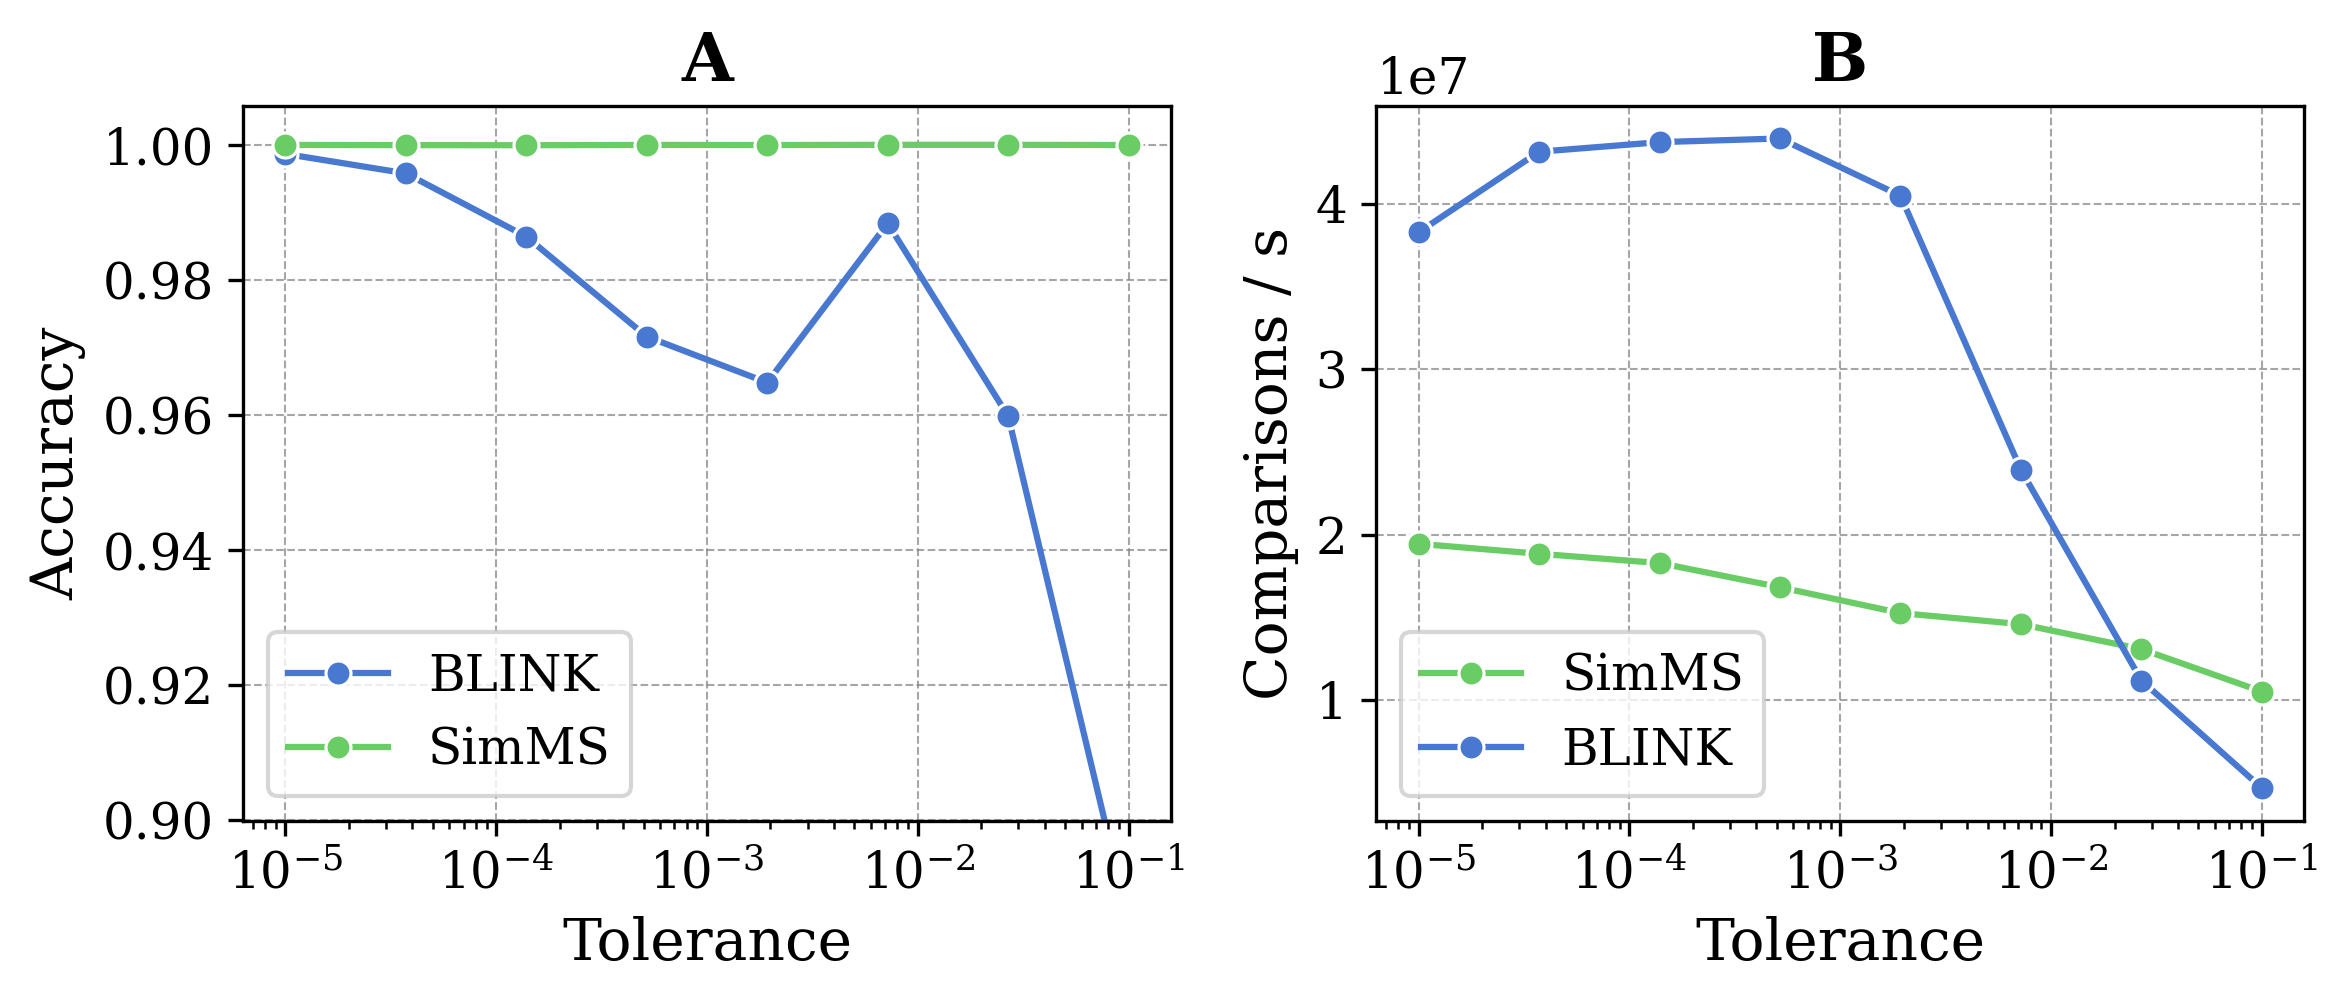

In [19]:
fig, axs = plt.subplot_mosaic(
    "ab",
    figsize=(8, 3.5),
)

prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = list(prop_cycle.by_key()["color"])
# perf_df["Bin Width"] = "BLINK " + perf_df.blink_bin_width.astype(str)
gp = perf_df.groupby("method")
plt.sca(axs["a"])
sns.lineplot(
    gp.get_group("blink"),
    x="tolerance",
    y="acc",
    # hue="Bin Width",
    palette="dark:r_r",
    marker="o",
    label="BLINK",
)
sns.lineplot(
    gp.get_group("simms"),
    x="tolerance",
    y="acc",
    color=colors[2],
    marker="o",
    label="SimMS",
)
plt.legend()
plt.title("A")
plt.xscale("log")
plt.ylim([0.8999, None])
plt.ylabel("Accuracy")
plt.xlabel("Tolerance")

plt.sca(axs["b"])
sns.lineplot(
    gp.get_group("simms"),
    x="tolerance",
    y="speed",
    color=colors[2],
    marker="o",
    label="SimMS",
)
sns.lineplot(
    gp.get_group("blink"),
    x="tolerance",
    y="speed",
    # hue="Bin Width",
    palette="dark:r_r",
    marker="o",
    label="BLINK",
)
plt.legend()
plt.title("B")
plt.xscale("log")
plt.xlabel("Tolerance")
plt.ylabel("Comparisons / s")

plt.tight_layout()
plt.savefig("fig04_blink_comparison.png", bbox_inches="tight")
plt.show()

In [20]:
perf_df

,method,tolerance,time,acc,speed,blink_bin_width
0,simms,0.000010,0.862668,0.999985,1.944806e+07,NaN
1,blink,0.000010,0.438465,0.998657,3.826356e+07,0.000010
2,simms,0.000037,0.890270,0.999954,1.884508e+07,NaN
3,blink,0.000037,0.388982,0.995773,4.313109e+07,0.000037
4,simms,0.000139,0.917586,0.999939,1.828408e+07,NaN
5,blink,0.000139,0.383839,0.986404,4.370901e+07,0.000139
6,simms,0.000518,0.997344,0.999985,1.682190e+07,NaN
7,blink,0.000518,0.381909,0.971588,4.392985e+07,0.000518
8,simms,0.001931,1.099127,0.999969,1.526412e+07,NaN
9,blink,0.001931,0.414525,0.964783,4.047335e+07,0.001000


In [5]:
import io
from pathlib import Path
import pandas as pd
from IPython.display import display


# For each notebook...
for nb in sorted(Path("notebooks/figures/performance/").glob("*.ipynb")):
    # Read the last cell's output as a JSON...
    nb_data = json.loads(nb.read_text())
    result_json = " ".join(nb_data["cells"][-1]["outputs"][0]["text"])
    res = pd.read_json(io.StringIO(result_json))
    display(res.head())

In [6]:
df = []
# For each notebook...
for nb in sorted(Path("./performance/").glob("*.ipynb")):
    # Read the last cell's output as a JSON...
    nb_data = json.loads(nb.read_text())
    result_json = " ".join(nb_data["cells"][-1]["outputs"][0]["text"])
    df.append(pd.read_json(io.StringIO(result_json)))

df = pd.concat(df, axis=0)
df

,kernel,time,pairs,label
0,CosineGreedy,3.345220,1024,MatchMS
1,ModifiedCosine,3.482526,1024,MatchMS
2,CosineGreedy,1.424222,1849,MatchMS
3,ModifiedCosine,3.620822,1849,MatchMS
4,CosineGreedy,1.503433,3364,MatchMS
...,...,...,...,...
25,CudaModifiedCosine,6.204502,63568729,H100SXM
26,CudaCosineGreedy,10.132120,159466384,H100SXM
27,CudaModifiedCosine,16.248677,159466384,H100SXM
28,CudaCosineGreedy,21.786473,400000000,H100SXM


/tmp/ipykernel_251143/1714221479.py:101: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0, 10e8])


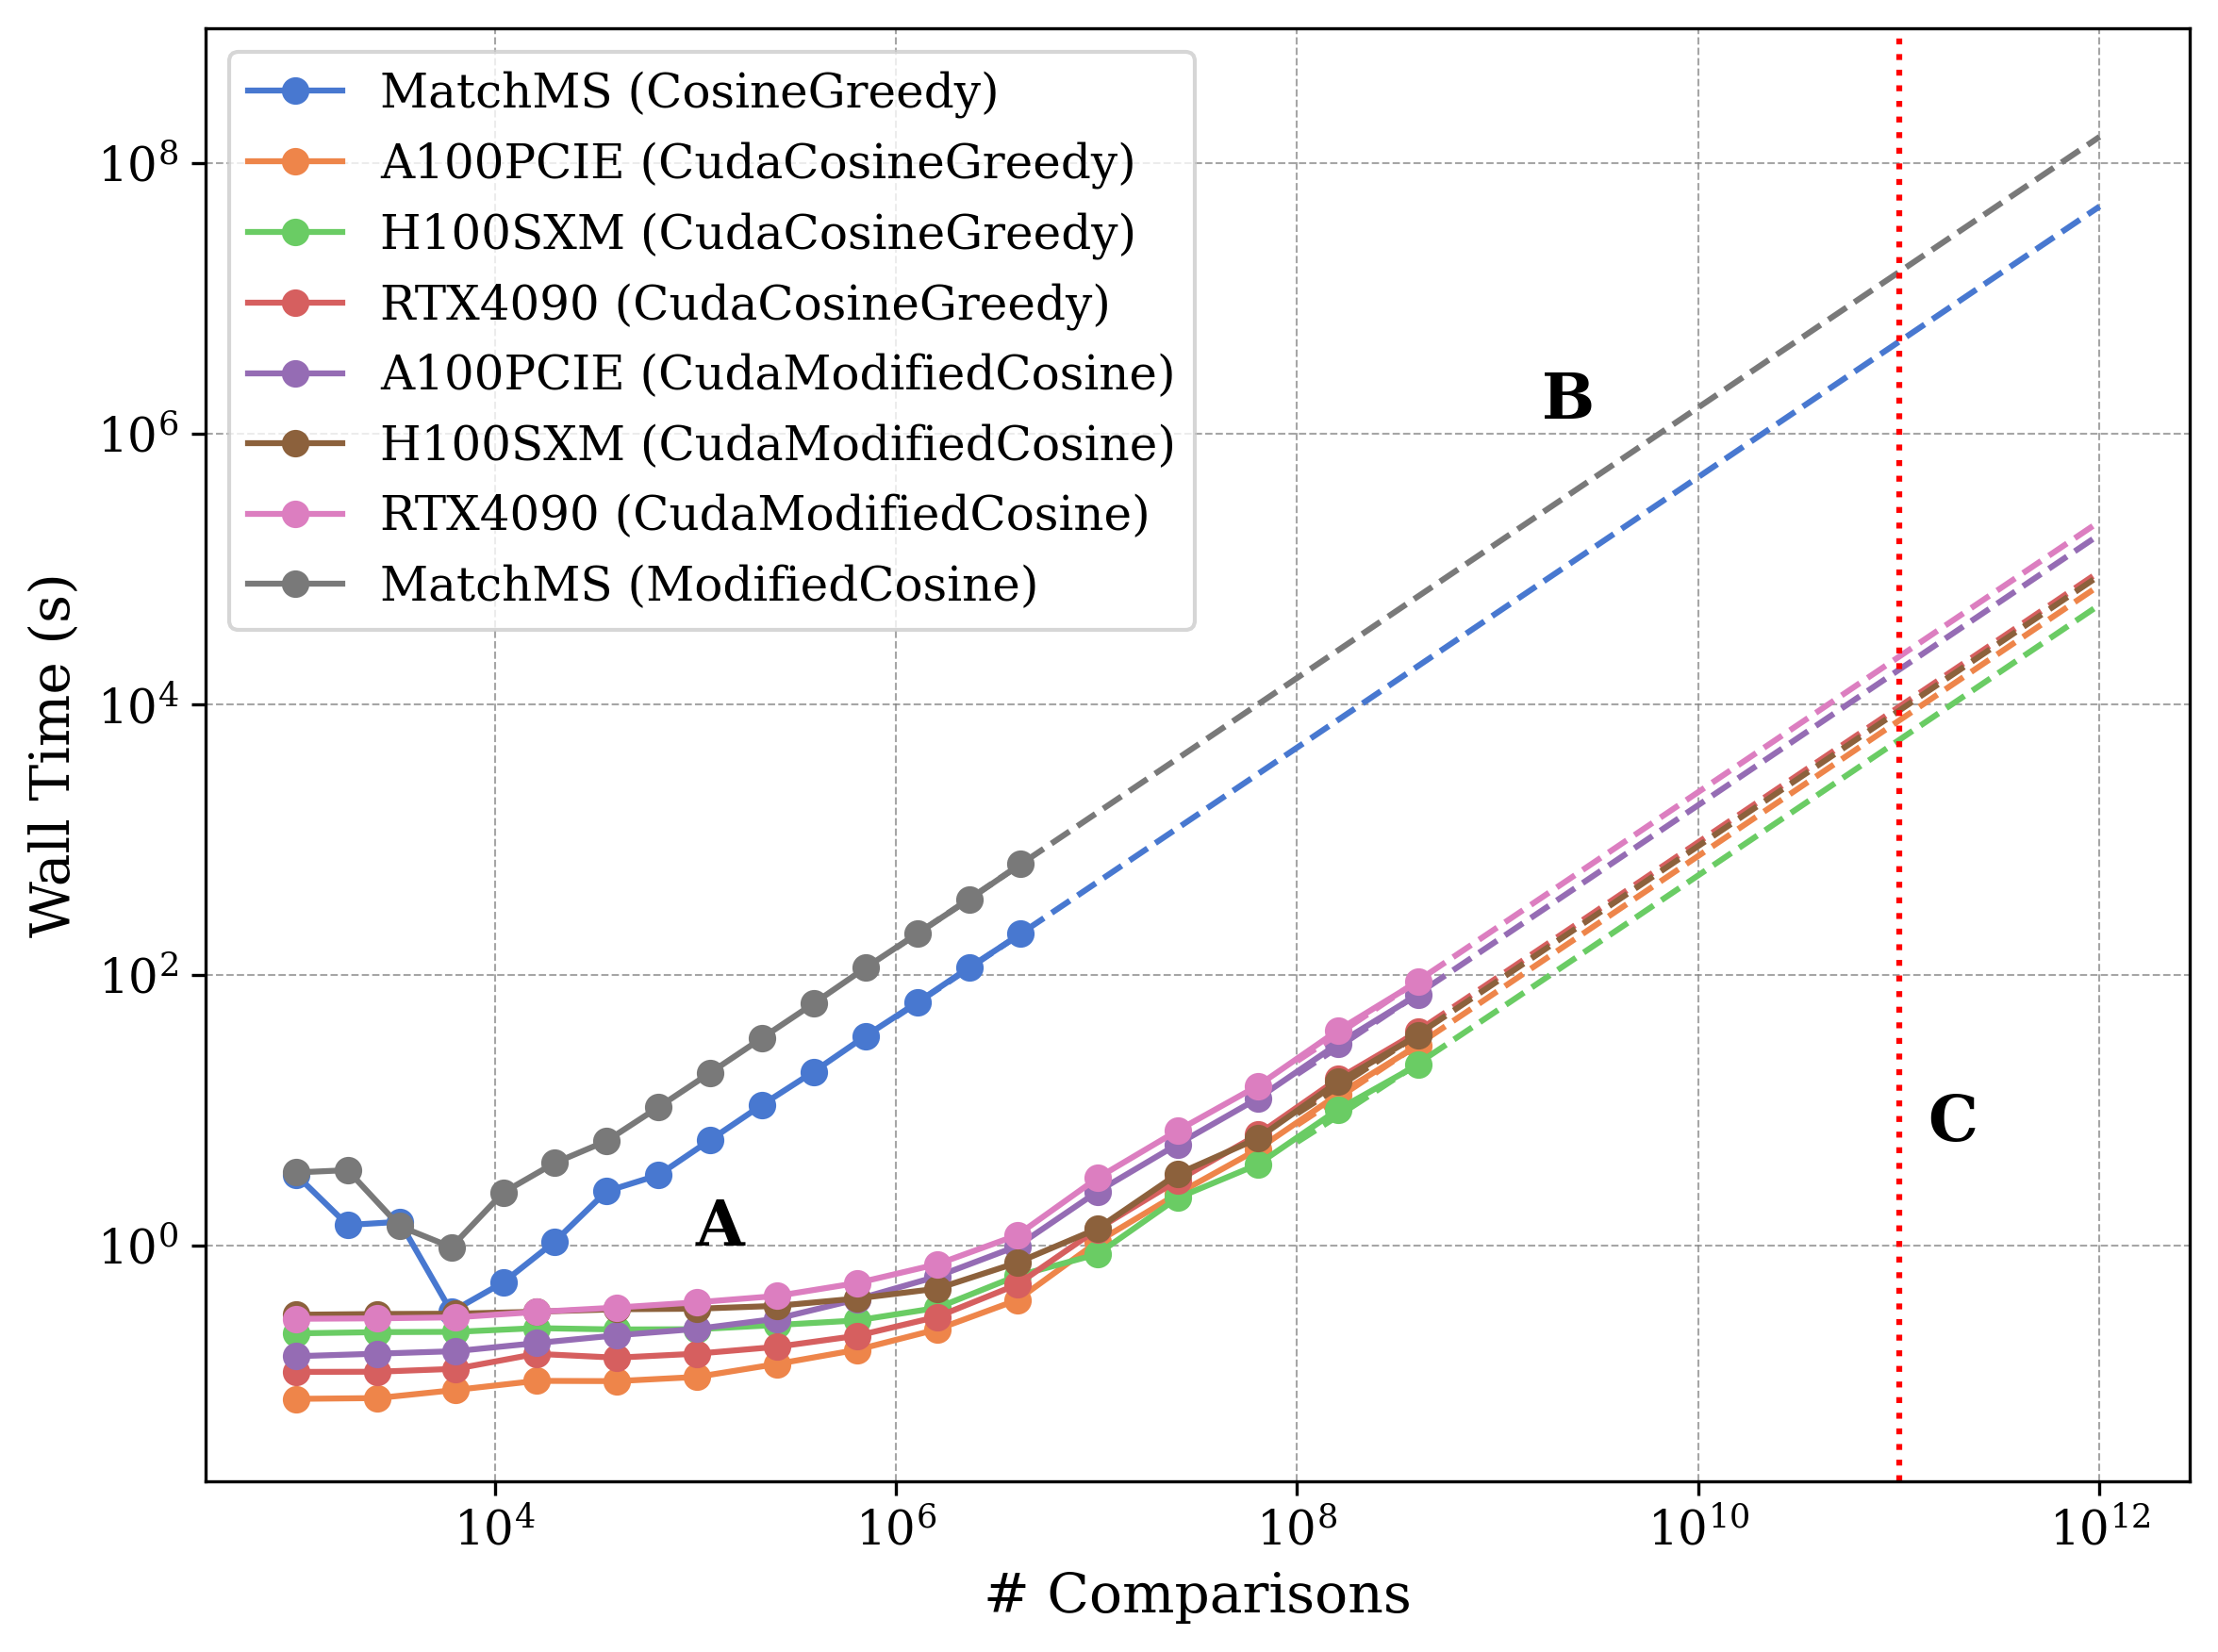

In [7]:
# Fancy formatter for time...
import io


def time_formatter(v: float, p) -> str:
    # def pluralify(s):
    #     a, b = s.split()
    #     if int(a) not in [0, 1]:
    #         s = s + "s"
    #     return s

    # if v < 60:  # Less than a minute
    # res = f"{int(v)} second"
    res = f"{v:.3e} second"
    # elif v < 3600:  # Less than an hour
    #     res = f"{int(v / 60)} minute"
    # elif v < 86400:  # Less than a day
    #     res = f"{int(v / 3600)} hour"
    # elif v < 604800:
    #     res = f"{int(v / 86400)} day"
    # elif v < 3.156e7:
    #     res = f"{int(v / 604800)} week"
    # else:
    #     res = f"{int(v / 3.156e+7)} year"
    # return pluralify(res)
    return res


df = []
# For each notebook...
for nb in sorted(Path("performance/").glob("*.ipynb")):
    # Read the last cell's output as a JSON...
    nb_data = json.loads(nb.read_text())
    result_json = " ".join(nb_data["cells"][-1]["outputs"][0]["text"])
    df.append(pd.read_json(io.StringIO(result_json)))
df = pd.concat(df, axis=0)

# For all sizes of experiments...
pairs_scale = np.logspace(
    np.log2(df.pairs.min()), np.log2(df.pairs.max()), base=2, dtype="float64", num=50
)

# Plot performance onto the same grid,
# NOTE: *Crucially* we extrapolate performance lines using linear regresion, to avoid actually wating for several days.


def plot_perf(axs: list[plt.Axes], df: pd.DataFrame = None):
    ###
    ax = axs[0]
    plt.sca(ax)
    perf_at_axvline = []
    for (kernel, label), data in df.groupby(["kernel", "label"]):

        if label == "MatchMS":
            interp_range = np.logspace(6, 12, 50).reshape(-1, 1)
        else:
            interp_range = np.logspace(8, 12, 50).reshape(-1, 1)

        estimate_runtime = LinearRegression()
        estimate_runtime.fit(np.array(data[["pairs"]]), np.array(data[["time"]]))
        estim_perf = estimate_runtime.predict(interp_range)

        p = plt.plot(
            data.pairs,
            data.time,
            marker="o",
            label=f"{label} ({kernel})",
            # ax=ax
        )

        plt.plot(
            interp_range.ravel(),
            estim_perf.ravel(),
            linestyle="--",
            # linewidth=0.5,
            color=p[-1].get_color(),
        )

        goal_num = 100_000 * 1_000_000
        perf_at_axvline.append(
            [label, goal_num / estimate_runtime.predict([[goal_num]]).item()]
        )

    # Our "target" is a real-world usecase we are facing, that we developed this kernel for.
    plt.legend()
    plt.vlines(
        goal_num,
        0,
        10e10,
        color="red",
        linestyle=":",
    )
    plt.text(goal_num * 1.4, 6, f"C", fontweight="bold", fontsize=16)
    plt.text(goal_num // 60, 1_300_000, f"B", fontweight="bold", fontsize=16)
    plt.text(0.1e6, 1, f"A", fontweight="bold", fontsize=16)

    plt.xlabel("# Comparisons")
    plt.ylabel("Wall Time (s)")
    plt.xscale("log")
    plt.yscale("log")
    plt.ylim([0, 10e8])
    # plt.ax.set_xticks(list(ax.get_xticks()) + [goal_num])
    # plt.ax.yaxis.set_major_formatter(plt.FuncFormatter(time_formatter))
    # plt.grid(True, "major", axis="y")


fig, axs = plt.subplots(1, 1, figsize=(8, 6))

plot_perf([axs], df=df)

plt.tight_layout()
plt.savefig("fig01_performance.png", bbox_inches="tight")
plt.show()

In [23]:
df

,kernel,time,pairs,label
0,CosineGreedy,3.345220,1024,MatchMS
1,ModifiedCosine,3.482526,1024,MatchMS
2,CosineGreedy,1.424222,1849,MatchMS
3,ModifiedCosine,3.620822,1849,MatchMS
4,CosineGreedy,1.503433,3364,MatchMS
...,...,...,...,...
25,CudaModifiedCosine,6.204502,63568729,H100SXM
26,CudaCosineGreedy,10.132120,159466384,H100SXM
27,CudaModifiedCosine,16.248677,159466384,H100SXM
28,CudaCosineGreedy,21.786473,400000000,H100SXM


/tmp/ipykernel_251143/2596058907.py:39: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.barplot(


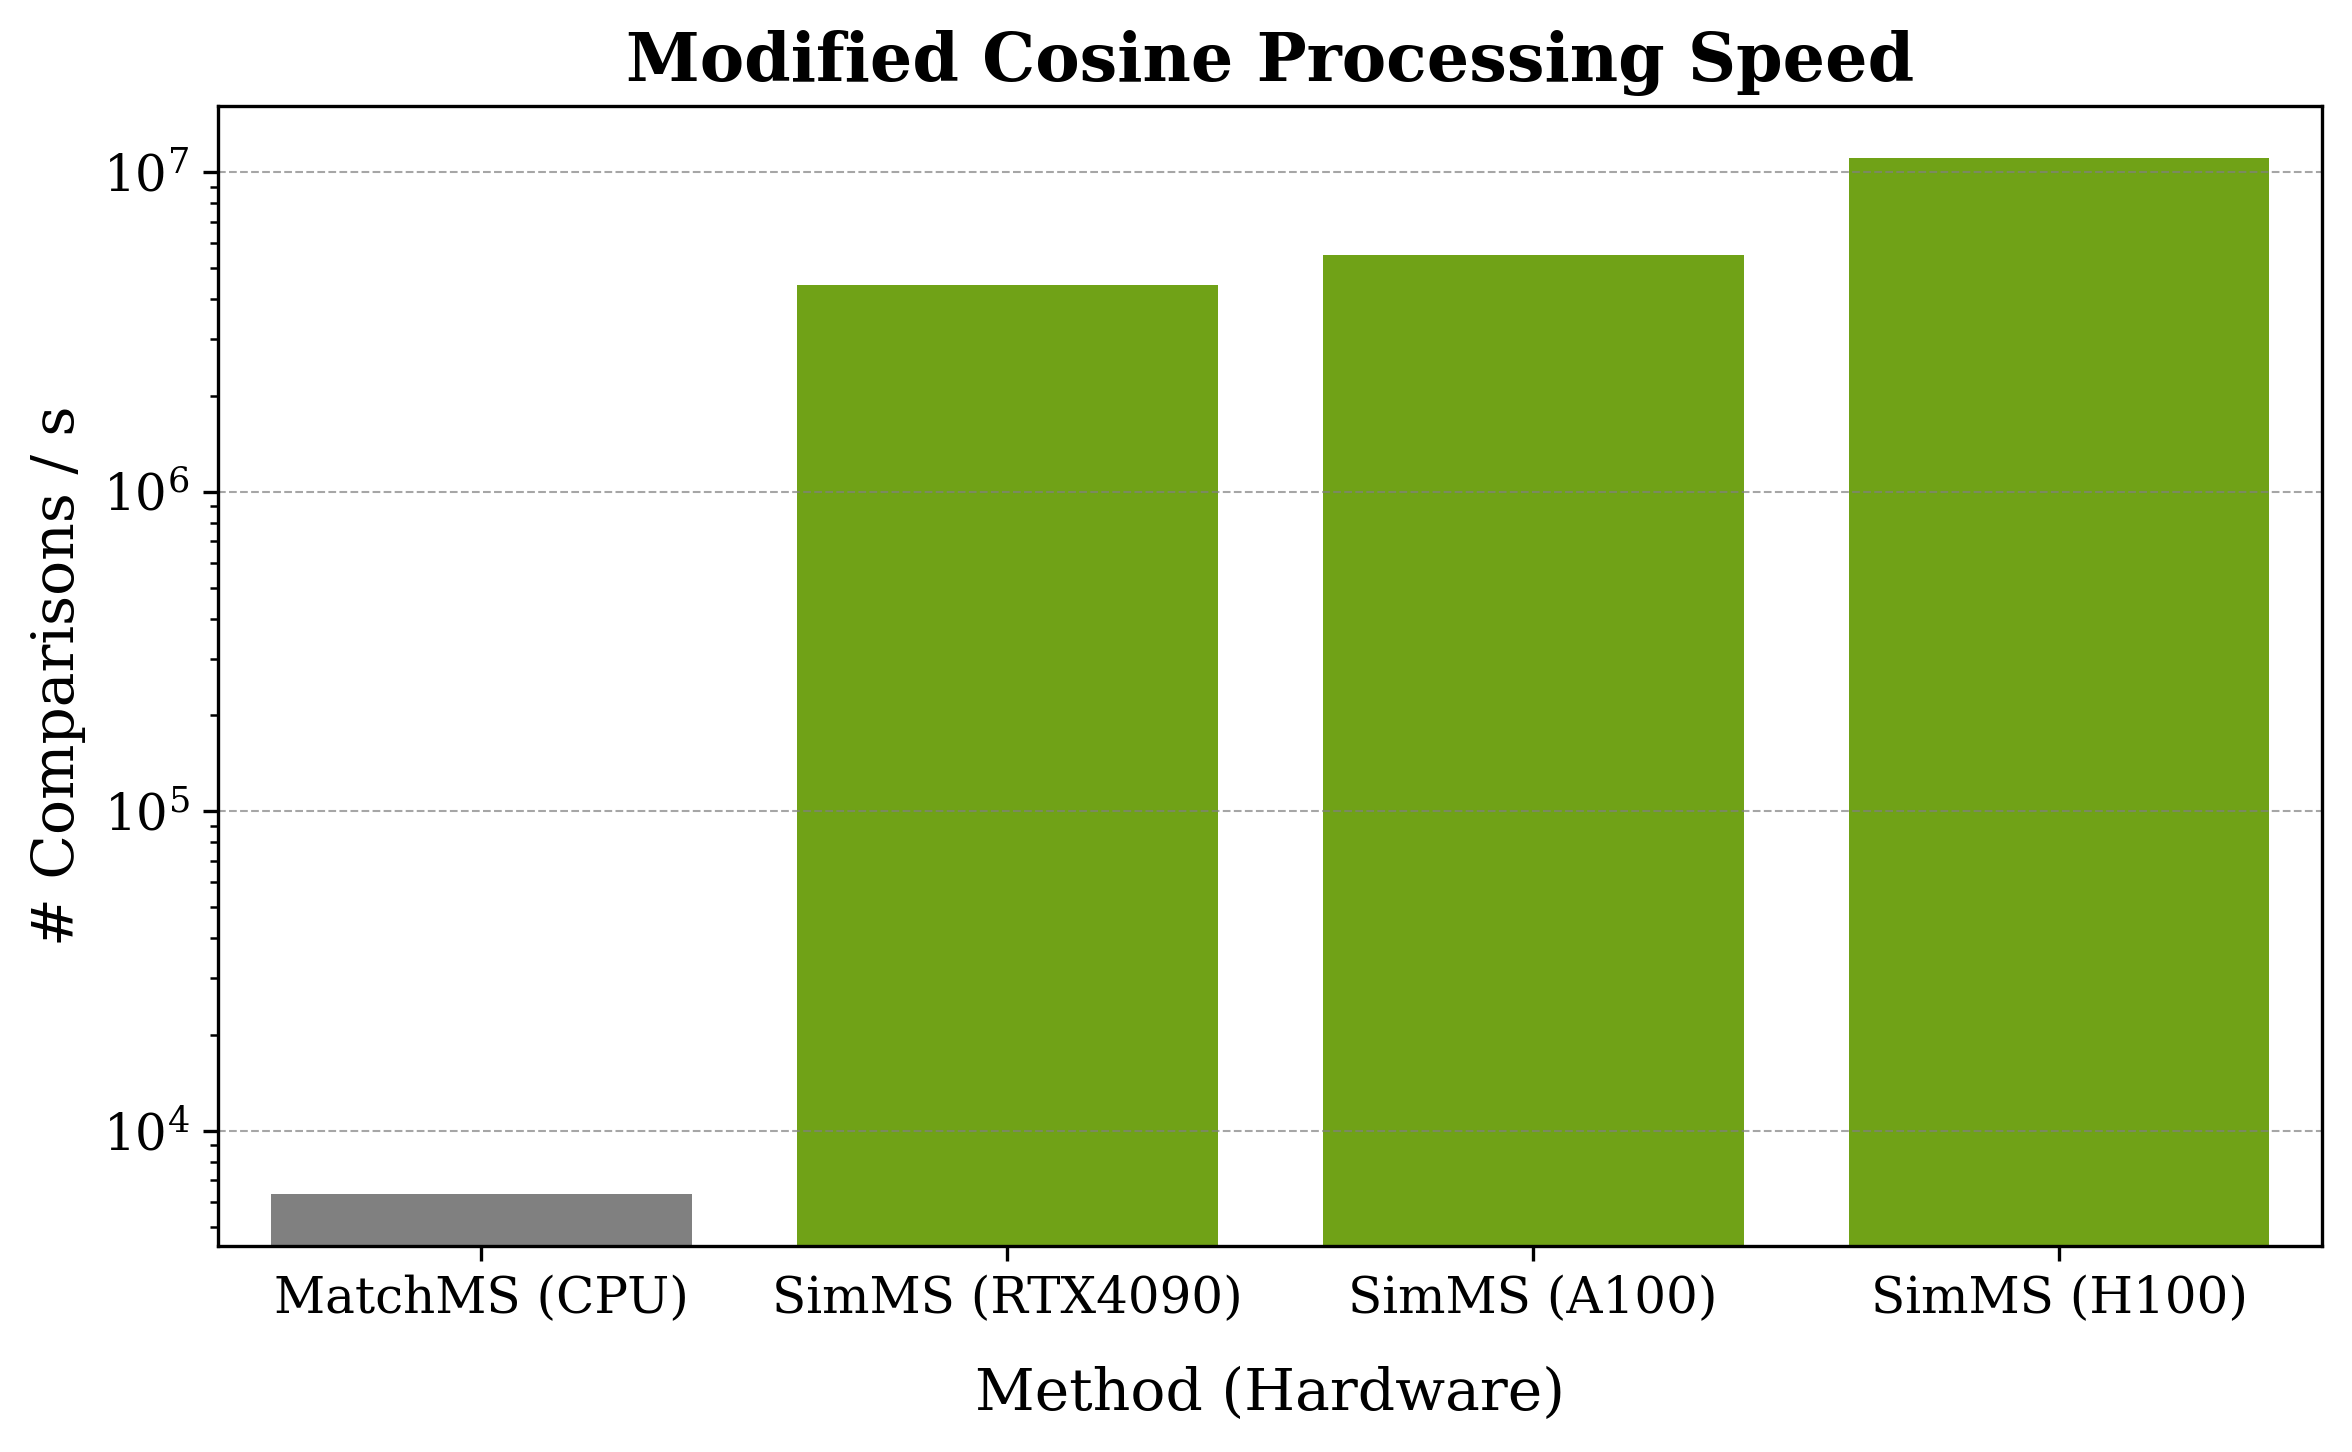

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression


goal_num = 100_000 * 1_500_000

# Filter dataframe for "ModifiedCosine" approaches
modified_cosine_df = df[df["kernel"].str.contains("ModifiedCosine")]

# Dictionary to store throughput at goal_num
performance_at_goal = []

# Estimate throughput for each approach at goal_num
for (kernel, label), data in modified_cosine_df.groupby(["kernel", "label"]):
    estimate_runtime = LinearRegression()
    estimate_runtime.fit(np.array(data[["pairs"]]), np.array(data[["time"]]))
    estimated_time_hr = estimate_runtime.predict([[goal_num]]).item()
    throughput = goal_num / estimated_time_hr
    performance_at_goal.append(
        {"kernel": kernel, "label": label, "throughput": throughput}
    )

# Convert to DataFrame
performance_df = pd.DataFrame(performance_at_goal)
performance_df = performance_df.sort_values("throughput")
# Set colors for CUDA and non-CUDA approaches
colors = [
    "gray" if "Cuda" not in kernel else "#76B900" for kernel in performance_df["kernel"]
]

# Organize x-axis labels
x_labels = ["MatchMS (CPU)", "SimMS (RTX4090)", "SimMS (A100)", "SimMS (H100)"]

# Plotting
plt.figure(figsize=(8, 5))
sns.barplot(
    data=performance_df,
    x="label",
    y="throughput",
    hue="kernel",
    dodge=False,
    palette=colors,
    legend=None,
)
plt.yscale("log")
plt.xlabel("Method (Hardware)", labelpad=10)
plt.ylabel("# Comparisons / s")
plt.title("Modified Cosine Processing Speed")
plt.grid(True, axis="y")
plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels)

plt.tight_layout()
plt.savefig("../../assets/perf_speedup.svg", bbox_inches="tight")
plt.show()

In [11]:
performance_df

,kernel,label,throughput
3,ModifiedCosine,MatchMS,6.345941e+03
2,CudaModifiedCosine,RTX4090,4.425520e+06
0,CudaModifiedCosine,A100PCIE,5.526844e+06
1,CudaModifiedCosine,H100SXM,1.109697e+07


In [26]:
!rm images.zip
!zip -r images.zip *.png

  adding: fig01_performance.png (deflated 12%)
  adding: fig02_direct_acc.png (deflated 10%)
  adding: fig03_tolerance_and_match_limit.png (deflated 21%)
  adding: fig04_blink_comparison.png (deflated 14%)


In [27]:
!du -hs *

168M	cache
820K	fig01_performance.png
1.8M	fig02_direct_acc.png
544K	fig03_tolerance_and_match_limit.png
368K	fig04_blink_comparison.png
2.9M	images.tar.gz
3.0M	images.zip
2.2M	make_figures.ipynb
24K	performance
